##### Seung-Hwan Oh, Seoul, Korea
##### Modified by Seung-Hwan Oh 2023.05.21
##### Do not copy without permission

# 1. json -> csv 컨버터

In [ ]:
import json
import numpy as np
import cv2
from PIL import Image
import pandas as pd

with open("labels_my-project-name.json", "r") as st_json:
    data = json.load(st_json)


In [ ]:
imageid = []
width = []
height = []
classid = []

rle = []

sdict = {}

for i in range(len(data['annotations'])):
    imageid.append(data['images'][i]['file_name'])
    width.append(data['images'][i]['width'])
    height.append( data['images'][i]['height'])
    classid.append(data["annotations"][i]['category_id'])


    segmentation_points = data["annotations"][i]["segmentation"][0]
    bbox = data["annotations"][i]["bbox"]
    segmentation_array = np.array(segmentation_points).reshape((-1, 2)).astype(np.int32)
    image_width = data["images"][i]["width"]
    image_height = data["images"][i]["height"]
    canvas = np.zeros((image_height, image_width), dtype=np.uint8)
    cv2.fillPoly(canvas, [segmentation_array], color=(255, 255, 255))
    output_file_name = "segmentation_image.jpg"
    cv2.imwrite(output_file_name, canvas)
    
    def binarize_image(image):
        # Convert the image to grayscale
        grayscale_image = image.convert('L')
        # Binarize the grayscale image using a threshold value
        threshold = 128  # Adjust the threshold value as needed
        binary_image = grayscale_image.point(lambda x: 0 if x < threshold else 255, '1')
        return binary_image
    def run_length_encode(mask):
        rle = []
        count = 0
        is_running = False
        # Iterate over each pixel in the mask
        for pixel in mask.getdata():
            if pixel == 255:  # Assuming 255 represents the object in the mask
                if not is_running:
                    start = count + 1  # Start of a new run
                    is_running = True
            else:
                if is_running:
                    length = count - start + 1  # Length of the run
                    rle.append((start, length))
                    is_running = False
            count += 1
        # Handle the case when the mask ends with a run
        if is_running:
            length = count - start + 1
            rle.append((start, length))
        return rle
    def run_length_decode(rle, mask_shape):
        mask = Image.new('L', mask_shape)
        for start, length in rle:
            for i in range(length):
                x = (start + i) % mask_shape[0]
                y = (start + i) // mask_shape[0]
                mask.putpixel((x, y), 255)  # Set pixel value to 255
        return mask
    # Load the original image
    image = Image.open('segmentation_image.jpg')
    # Binarize the image
    binary_image = binarize_image(image)
    # Run-length encode the binary mask
    rle_encoded = run_length_encode(binary_image)
    rle_encoded = ' '.join([' '.join([str(i[0]),str(i[1])]) for i in rle_encoded])
    rle.append(rle_encoded)

In [ ]:
import pandas as pd

f = pd.DataFrame({'imageid':imageid,
                    'EncodedPixcels': rle,
                    'width':width, 
                    'height':height, 
                    'classid':classid})

f.to_csv("data.csv",index=False)

# Data 설명 

### 데이터 출처 (https://www.kaggle.com/competitions/imaterialist-fashion-2019-FGVC6/data)

/U2-net/imaterialist 경로안에

train.csv와 train폴더안에 인풋 이미지를 주시면됩니다.

## imaterialist 구조

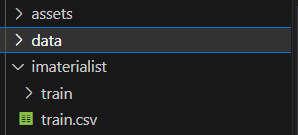

## train.csv 구조

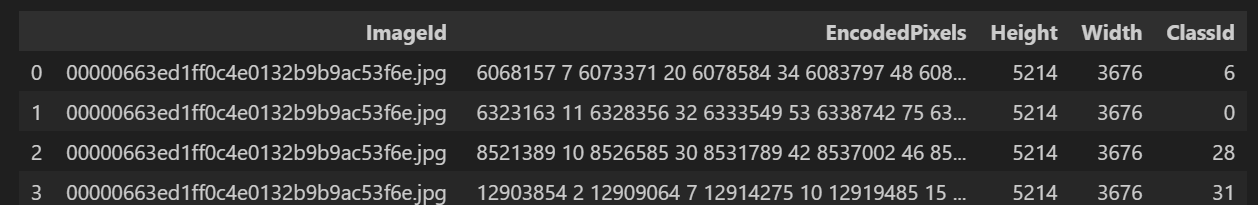

## 인풋 이미지 1개 예시


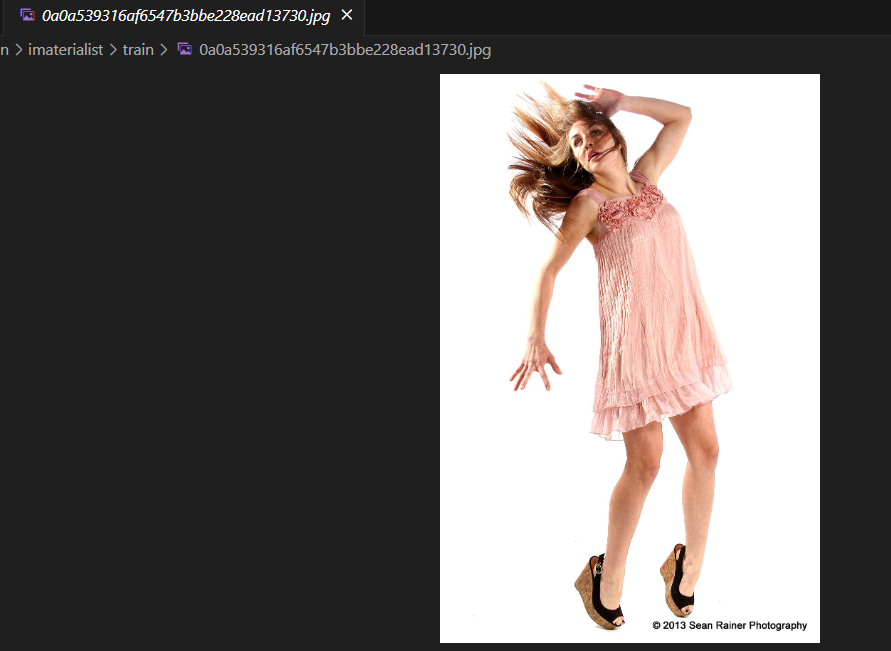

# 아래부터는 정리 코드

In [6]:
# torch 설치
# !conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia -y


In [4]:
# git 설치
!conda install git -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ohseunghwan/anaconda3/envs/soomgo

  added / updated specs:
    - git


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    curl-7.88.1                |       h5eee18b_0          88 KB
    gdbm-1.18                  |       hd4cb3f1_4         194 KB
    gettext-0.21.0             |       h39681ba_1         3.0 MB
    git-2.34.1                 | pl5262hc120c5b_0         6.0 MB
    libxml2-2.10.3             |       hcbfbd50_0         755 KB
    pcre2-10.37                |       he7ceb23_1         839 KB
    perl-5.34.0                |       h5eee18b_2        12.4 MB
    ------------------------------------------------------------
    

# 오승환 고수가 수정한 코드 불러오기

In [1]:
#오승환 고수가 수정한 코드 불러오기
!git clone https://github.com/shiny0510/U2-net.git

Cloning into 'U2-net'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 57 (delta 3), reused 56 (delta 2), pack-reused 0
Receiving objects: 100% (57/57), 2.40 MiB | 5.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [29]:
!pip install pyyaml
!pip install opencv-python
!conda install tensorboard
!pip install pandas

  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)


### U2-net/imaterialist 경로안에 이미지 데이터와 train.csv를 만드셨다면, 그냥 돌리시면 됩니다

In [3]:
!python ./U2-net/train.py 

name training_cloth_segm_u2net_exp1
image_folder ./cloth-segmentation/imaterialist/train/
df_path ./cloth-segmentation/imaterialist/train.csv
distributed False
isTrain True
fine_width 768
fine_height 768
mean 0.5
std 0.5
batchSize 2
nThreads 2
max_dataset_size inf
serial_batches False
continue_train False
save_freq 1000
print_freq 10
image_log_freq 100
iter 100000
lr 0.0002
clip_grad 5
logs_dir logs/training_cloth_segm_u2net_exp1
save_dir results/training_cloth_segm_u2net_exp1
cuda:0
dataset [AlignedDataset] was created
Traceback (most recent call last):
  File "./U2-net/train.py", line 181, in <module>
    training_loop(opt)
  File "./U2-net/train.py", line 90, in training_loop
    custom_dataloader.initialize(opt)
  File "/home/ohseunghwan/test/U2-net/data/custom_dataset_data_loader.py", line 21, in initialize
    self.dataset = CreateDataset(opt)
  File "/home/ohseunghwan/test/U2-net/data/custom_dataset_data_loader.py", line 11, in CreateDataset
    dataset.initialize(opt)
  File "/